## Part 2a: generate disv properties

In [3]:
import sys, json, os ## Org
import rasterio, flopy ## Org
import numpy as np ## Org
import matplotlib.pyplot as plt ## Org
import geopandas as gpd ## Org
from mf6Voronoi.meshProperties import meshShape ## Org
from shapely.geometry import MultiLineString ## Org

C:\Users\saulm\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\saulm\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\saulm\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
C:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:93: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in P

In [4]:
# open the json file
with open('json/disvDict.json') as file: ## Org
    gridProps = json.load(file) ## Org

In [5]:
cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list
vertices = gridProps['vertices']       #vertex id and xy coordinates
ncpl = gridProps['ncpl']               #number of cells per layer
nvert = gridProps['nvert']             #number of verts
centroids=gridProps['centroids']       #cell centroids xy 

## Part 2b: Model construction and simulation

In [7]:
#Extract dem values for each centroid of the voronois
src = rasterio.open('rst/elevWgs18S.tif')  
elevation=[x for x in src.sample(centroids)] 

In [8]:
nlay = 15 

mtop=np.array([elev[0] for i,elev in enumerate(elevation)]) ## Org
zbot=np.zeros((nlay,ncpl)) ## Org


AcuifInf_Bottom = 3200 
zbot[0,] = AcuifInf_Bottom + (0.975 * (mtop - AcuifInf_Bottom)) 
zbot[1,] = AcuifInf_Bottom + (0.95 * (mtop - AcuifInf_Bottom)) 
zbot[2,] = AcuifInf_Bottom + (0.925 * (mtop - AcuifInf_Bottom)) 
zbot[3,] = AcuifInf_Bottom + (0.9 * (mtop - AcuifInf_Bottom)) 
zbot[4,] = AcuifInf_Bottom + (0.875 * (mtop - AcuifInf_Bottom)) 
zbot[5,] = AcuifInf_Bottom + (0.85 * (mtop - AcuifInf_Bottom))
zbot[6,] = AcuifInf_Bottom + (0.825 * (mtop - AcuifInf_Bottom))
zbot[7,] = AcuifInf_Bottom + (0.8 * (mtop - AcuifInf_Bottom)) 
zbot[8,] = AcuifInf_Bottom + (0.775 * (mtop - AcuifInf_Bottom))
zbot[9,] = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom))
zbot[10,] = AcuifInf_Bottom + (0.725 * (mtop - AcuifInf_Bottom))
zbot[11,] = AcuifInf_Bottom + (0.7 * (mtop - AcuifInf_Bottom))
zbot[12,] = AcuifInf_Bottom + (0.675 * (mtop - AcuifInf_Bottom)) 
zbot[13,] = AcuifInf_Bottom + (0.40 * (mtop - AcuifInf_Bottom)) 
zbot[14,] = AcuifInf_Bottom ## Org

### Create simulation and model

In [10]:
# create simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = 'modelFiles' ## Org
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', ## Org
                             exe_name='bin/mf6.exe', ## Org
                             sim_ws=modelWs) ## Org

In [11]:
# create tdis package
tdis_rc = [(1.0, 1, 1.0)] + [(86400*365, 1, 1.0) for level in range(5)]
print(tdis_rc)

tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                             perioddata=tdis_rc,
                            nper=6) 


[(1.0, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0), (31536000, 1, 1.0)]


In [12]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, ## Org
                           modelname=modelName, ## Org
                           save_flows=True, ## Org
                           newtonoptions="NEWTON UNDER_RELAXATION") ## Org

In [13]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, ## Org
                           complexity='COMPLEX', ## Org
                           outer_maximum=150, 
                           inner_maximum=50, 
                           outer_dvclose=0.1,
                           inner_dvclose=0.0001,
                           backtracking_number=20,
                           linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(ims,[modelName]) ## Org

In [14]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, ## Org
                                top=mtop, botm=zbot, ## Org
                                nvert=nvert, vertices=vertices, ## Org
                                cell2d=cell2d) ## Org

<Axes: title={'center': 'top'}>

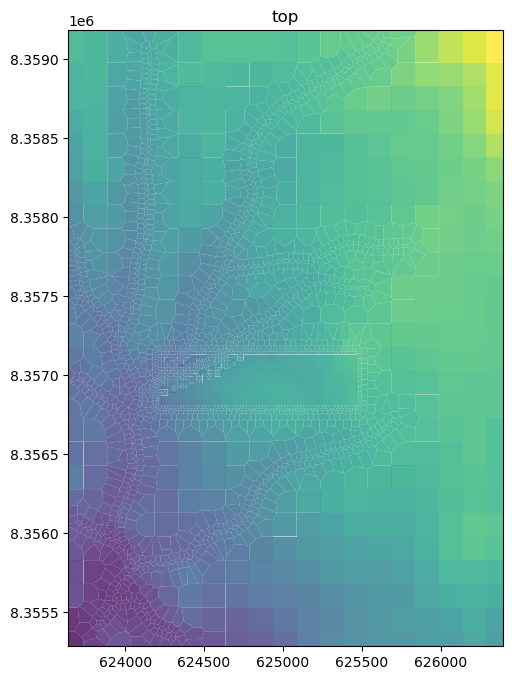

In [15]:
disv.top.plot(figsize=(12,8), alpha=0.8)

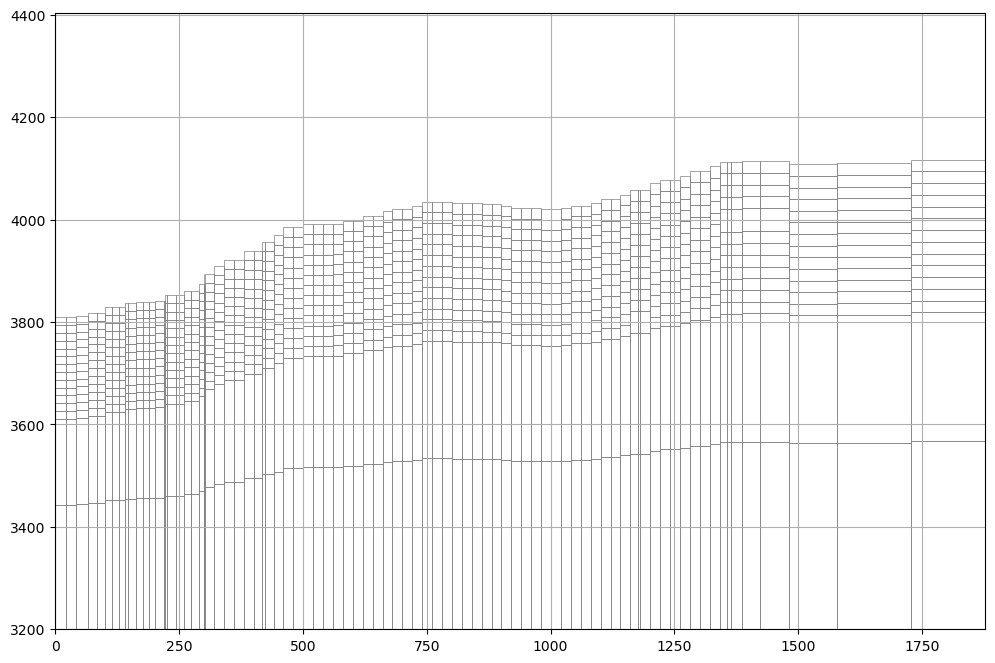

In [16]:
crossSection = gpd.read_file('shp/crossSection.shp')
sectionLine =list(crossSection.iloc[0].geometry.coords)

fig, ax = plt.subplots(figsize=(12,8))
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine})
linecollection = modelxsect.plot_grid(lw=0.5)
ax.grid()

In [17]:
# initial conditions
headsInitial = np.load('npy/headCalibInitial.npy')
#ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)])) ## Org
ic = flopy.mf6.ModflowGwfic(gwf, strt=headsInitial)

In [18]:
Kx =[4E-4] + [7E-7 for x in range(4)] + [3E-7 for x in range(4)] + [1E-7 for x in range(6)] 
icelltype = [1 for x in range(10)] + [0 for x in range(5)]

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, ## Org
                              save_specific_discharge=True, ## Org
                              icelltype=icelltype, ## Org
                              k=Kx,
                              k33=np.array(Kx)/10) 

In [19]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, ## Org
                              iconvert=1, ## Org
                              steady_state={ ## Org
                                0:True, ## Org
                              },
                              transient={
                                  1:True,
                                  2:True,
                                  3:True,
                                  4:True,
                                  5:True
                              },
                              ss=1e-06,
                              sy=0.001,
                              ) ## Org

#### Working with rechage, evapotranspiration

In [21]:
rchr = 0.2/365/86400
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr) ## Org
evtr = 1.2/365/86400 
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0) ## Org

### Definition of the intersect object
For the manipulation of spatial data to determine hydraulic parameters or boundary conditions

In [23]:
# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org

In [24]:
#open the river shapefile
rivers =gpd.read_file('shp/riversSpart.shp')
list_rivers=[] ## Org
for i in range(rivers.shape[0]): ## Org
    list_rivers.append(rivers['geometry'].loc[i]) ## Org
    
riverMls = MultiLineString(lines=list_rivers) ## Org

#intersec rivers with our grid
riverCells=interIx.intersect(riverMls).cellids ## Org
riverCells[:10] ## Org

array([0, 3, 18, 20, 33, 34, 35, 40, 51, 53], dtype=object)

In [25]:
#river package
riverSpd = {} ## Org
riverSpd[0] = [] ## Org
for cell in riverCells: ## Org
    riverSpd[0].append([(0,cell),mtop[cell],0.01]) ## Org

tunelDict = {
    'Level4000' : {
        'path' : 'shp/Level4000.shp',
        'level' : 4000,
        'kper' : 1
    },
    'Level3950' : {
        'path' : 'shp/Level3950.shp',
        'level' : 3950,
        'kper' : 2
    },
    'Level3900' : {
        'path' : 'shp/Level3900.shp',
        'level' : 3900,
        'kper' : 3
    },
    'Level3850' : {
        'path' : 'shp/Level3850.shp',
        'level' : 3850,
        'kper' : 4
    },
    'Level3800' : {
        'path' : 'shp/Level3800.shp',
        'level' : 3800,
        'kper' : 5
    },
}

In [26]:
nlay = disv.nlay.data
topBotm = gwf.modelgrid.top_botm

for index, tunel in tunelDict.items():
    tunelDf = gpd.read_file(tunel['path'])
    list_tunel=[] 
    for i in range(tunelDf.shape[0]): 
        list_tunel.append(tunelDf['geometry'].loc[i]) 
    tunelMls = MultiLineString(lines=list_tunel)
    #cellList = []
    tunelCells = interIx.intersect(tunelMls).cellids
    cellList = []
    for cell in tunelCells:
        for lay in range(nlay):  # Loop through layers
            if topBotm[lay+1, cell] <= tunel['level'] <= topBotm[lay,cell]:
                cellList.append([(lay,cell),tunel['level'],1])
    riverSpd[tunel['kper']] = riverSpd[tunel['kper']-1] + cellList

In [27]:
riv = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=riverSpd) 

[<Axes: title={'center': ' drn_0 location stress period 6 layer 4'}>]

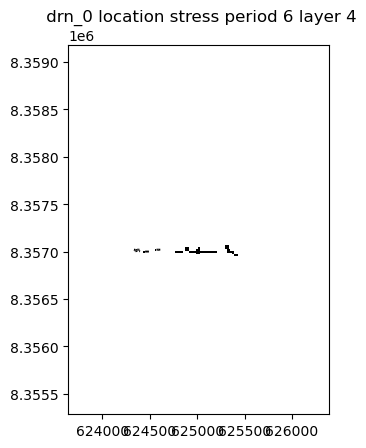

In [28]:
#river plot
riv.plot(mflay=3, kper=5) 

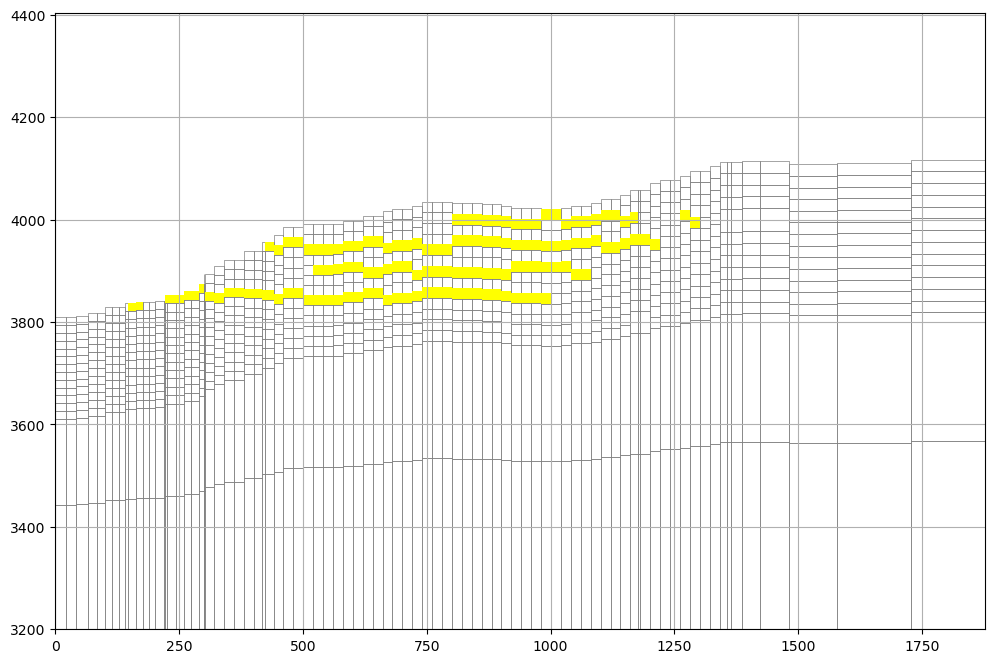

In [29]:
crossSection = gpd.read_file('shp/crossSection.shp')
sectionLine =list(crossSection.iloc[0].geometry.coords)

fig, ax = plt.subplots(figsize=(12,8))
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine})
lc = xsect.plot_grid(lw=0.5)
xsect.plot_bc('DRN',kper=4)
ax.grid()

In [30]:
## working with the regional flow as ghb

#open the river shapefile
regionalDf =gpd.read_file('shp/regionalFlow.shp')

#intersec regional flow with our grid
regCells=interIx.intersect(regionalDf.iloc[0].geometry).cellids 
print(regCells[:10]) 

regCentroids = []
xCenters = gwf.modelgrid.xcellcenters
yCenters = gwf.modelgrid.ycellcenters
for cell in regCells:
    regCentroids.append([xCenters[cell],yCenters[cell]])
print(regCentroids[:5])

#Extract dem values for each centroid of the voronois
src = rasterio.open('rst/waterTable.tif')  
elevation=[x[0] for x in src.sample(regCentroids)] 

regArray = np.array(regCentroids)
xyzRegional = list(zip(regArray[:,0],regArray[:,1],elevation))
print(len(xyzRegional))
xyzRegional[:5]

[1 2 4 5 7 8 9 10 12 13]
[[623688.6774195321, 8358153.113530544], [623661.1788449725, 8357808.973223856], [623671.6367002102, 8355456.020837054], [623684.279967208, 8357128.817213701], [624387.907568467, 8355296.586157048]]
133


[(623688.6774195321, 8358153.113530544, 3893.8487739132543),
 (623661.1788449725, 8357808.973223856, 3870.580700784055),
 (623671.6367002102, 8355456.020837054, 3627.764728938433),
 (623684.279967208, 8357128.817213701, 3807.0397104257454),
 (624387.907568467, 8355296.586157048, 3683.512325050922)]

In [31]:
regSpd = {} 
regList = []

for index, reg in enumerate(xyzRegional):
    try:
        lay, cell = gwf.modelgrid.intersect(reg[0],reg[1],reg[2])
        regList.append([(lay,cell), reg[2], 0.03])
        if index % 20 == 0:
            print(index)
    except Exception:
        pass

regSpd = {} 
regSpd[0] = regList
regSpd[1] = regList
regSpd[2] = regList
regSpd[3] = regList
regSpd[4] = regList
regSpd[5] = regList

ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=regSpd)

0
40
60
80
100
120


[<Axes: title={'center': ' ghb_0 location stress period 1 layer 9'}>]

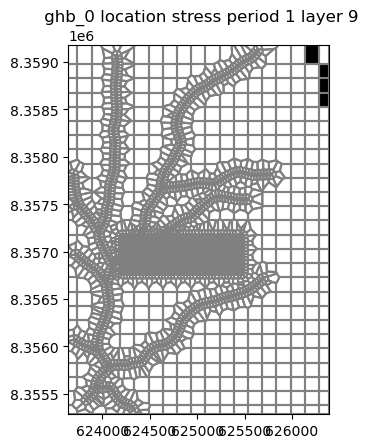

In [32]:
ghb.plot(mflay=8, grid=True)

### Set the Output Control and run simulation

In [34]:
#oc
head_filerecord = f"{gwf.name}.hds" ## Org
oc = flopy.mf6.ModflowGwfoc(gwf, ## Org
                            head_filerecord=head_filerecord, ## Org
                            saverecord=[("HEAD", "LAST")]) ## Org

In [35]:
# Run the simulation
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6Model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 783 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 113 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\Bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:10:16 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applicatio

### Model output visualization

In [37]:
headObj = gwf.output.head() ## Org
headObj.get_kstpkper() ## Org

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

In [38]:
kper = 5 
lay = 0

In [39]:
heads = headObj.get_data(kstpkper=(0,0)) 
heads2 = headObj.get_data(kstpkper=(0,5)) 
#heads[lay,0,:5] 
#heads = headObj.get_data(kstpkper=(0,0)) 
#np.save('npy/headCalibInitial', heads)

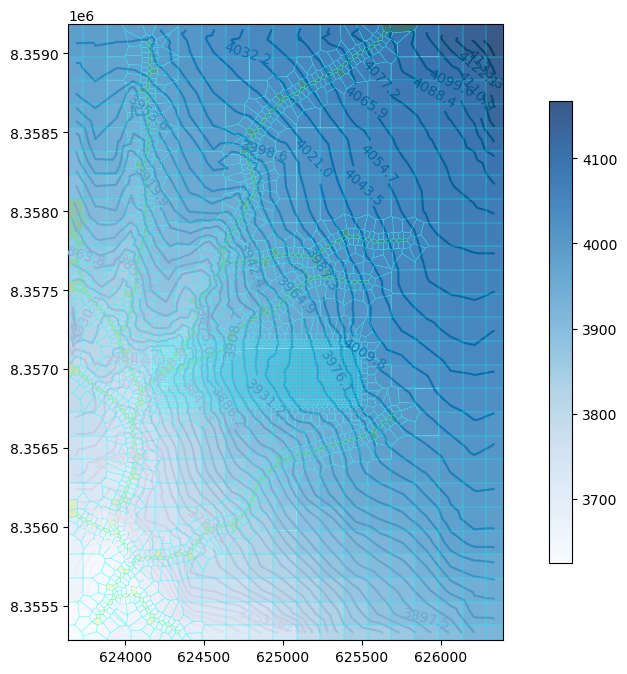

In [40]:
### Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8)) ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal') ## Org
modelmap = flopy.plot.PlotMapView(model=gwf) ## Org

####
levels = np.linspace(heads[heads>-1e+30].min(),heads[heads>-1e+30].max(),num=50) ## Org
contour = modelmap.contour_array(heads[lay],ax=ax,levels=levels,cmap='PuBu') 
ax.clabel(contour) ## Org


quadmesh = modelmap.plot_bc('DRN') ## Org
cellhead = modelmap.plot_array(heads[lay],ax=ax, cmap='Blues', alpha=0.8) 

linecollection = modelmap.plot_grid(linewidth=0.3, alpha=0.5, color='cyan', ax=ax) ## Org

plt.colorbar(cellhead, shrink=0.75) ## Org

plt.show() ## Org

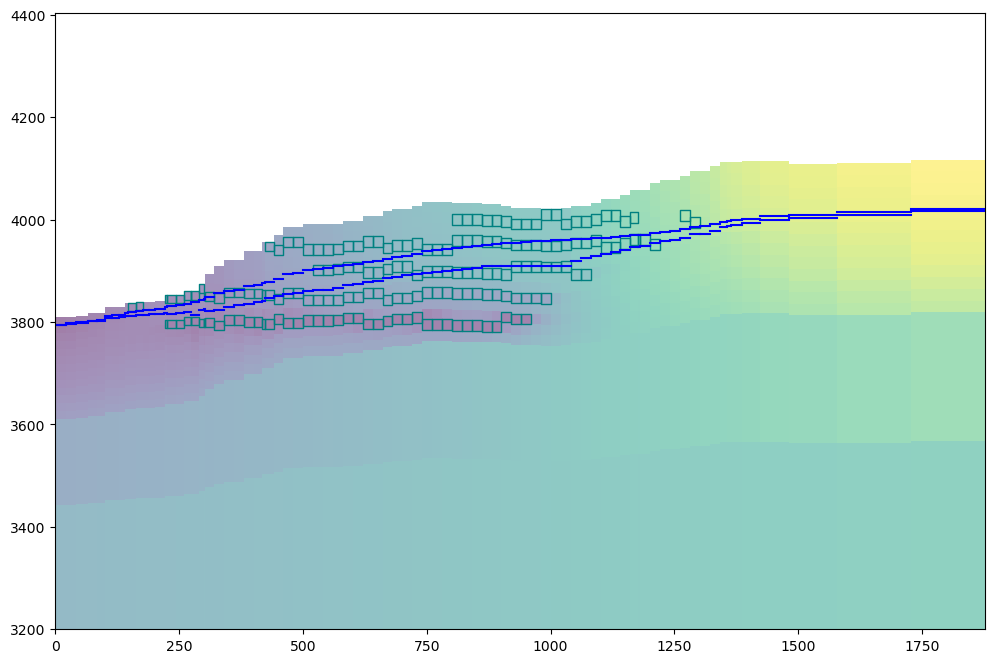

In [41]:
crossSection = gpd.read_file('shp/crossSection.shp')
sectionLine =list(crossSection.iloc[0].geometry.coords)

waterTable = flopy.utils.postprocessing.get_water_table(heads)
waterTable2 = flopy.utils.postprocessing.get_water_table(heads2)

fig, ax = plt.subplots(figsize=(12,8))
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine})
lc = modelxsect.plot_grid(lw=0.5)
xsect.plot_array(heads2, alpha=0.5)
xsect.plot_surface(waterTable)
xsect.plot_surface(waterTable2)
xsect.plot_bc('drn', kper=kper, facecolor='none', edgecolor='teal')
plt.show()